In [23]:
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd

In [24]:
dataset = load_breast_cancer()
X = dataset.data
y = dataset.target

In [25]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = {'RF': [], 'NB': [], 'LSTM': []}

In [26]:
fpr_rf, tpr_rf, auc_rf = [], [], []
fpr_nb, tpr_nb, auc_nb = [], [], []
fpr_lstm, tpr_lstm, auc_lstm = [], [], []

In [27]:
def calculate_evaluation_metrics(y_true, y_pred, y_prob=None, fpr=None, tpr=None):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    P = TP + FN  #Total positives (P)
    N = TN + FP  #Total negatives (N)

    tpr_value = TP / P if P > 0 else 0  # True Positive Rate (Sensitivity)
    tnr_value = TN / N if N > 0 else 0  # True Negative Rate (Specificity)
    fpr_value = FP / N if N > 0 else 0  # False Positive Rate
    fnr_value = FN / P if P > 0 else 0  # False Negative Rate
    error_rate = (FP + FN) / (P + N)  # Error Rate
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred)
    auc_value = auc(fpr, tpr) if fpr is not None and tpr is not None else None

    bacc = (TP / (TP + FN) + TN / (TN + FP)) / 2  # Balanced Accuracy
    tss = (TP / (TP + FN)) - (FP / (FP + TN))  # True Skill Statistic
    hss = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))  # Heidke Skill Score

    bs = brier_score_loss(y_true, y_prob) if y_prob is not None else None
    bss = None
    if y_prob is not None:
        y_mean = np.mean(y_true)
        bss = 1 - (bs / np.mean((y_true - y_mean) ** 2))

    return {
        'Positive Examples (P)': P,
        'Negative Examples (N)': N,
        'True Positive Rate (TPR)': tpr_value,
        'True Negative Rate (TNR)': tnr_value,
        'False Positive Rate (FPR)': fpr_value,
        'False Negative Rate (FNR)': fnr_value,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc_value,
        'Balanced Accuracy (BACC)': bacc,
        'True Skill Statistics (TSS)': tss,
        'Heidke Skill Score (HSS)': hss,
        'Brier Score (BS)': bs,
        'Brier Skill Score (BSS)': bss,
        'Error Rate (ERR)': error_rate
    }

In [28]:
def build_roc(fpr_list, tpr_list, num_points=100):
    mean_fpr = np.linspace(0, 1, num_points)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    mean_tpr = np.insert(mean_tpr, 0, 0)
    mean_fpr = np.insert(mean_fpr, 0, 0)
    return mean_fpr, mean_tpr

In [29]:
def calculate_averages(metrics_list):
    averages = {}
    for metric in metrics_list[0]:
        valid_values = [metrics[metric] for metrics in metrics_list if metrics[metric] is not None]
        averages[metric] = np.mean(valid_values) if valid_values else None
    return averages

# Random Forest Model

In [30]:
all_evaluation_metrics_rf = []
print("\033[1m" + "\n10 FOLD METRICS FOR RANDOM FOREST\n" + "\033[0m")
print()
for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
    
    #Calculating all evaluation metrics for Random Forest
    fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
    metrics_rf = calculate_evaluation_metrics(y_test, y_pred_rf, y_prob_rf, fpr, tpr)
    fpr_rf.append(fpr)
    tpr_rf.append(tpr)
    auc_rf.append(auc(fpr, tpr))

    all_evaluation_metrics_rf.append(metrics_rf)

    #Printing metrics for all 10 folds
    print(f"Random Forest - Fold {i}")
    for metric, value in metrics_rf.items():
        print(f"{metric}: {value}")
    print()
print()


10 FOLD METRICS FOR RANDOM FOREST


Random Forest - Fold 1
Positive Examples (P): 40
Negative Examples (N): 17
True Positive Rate (TPR): 0.975
True Negative Rate (TNR): 0.9411764705882353
False Positive Rate (FPR): 0.058823529411764705
False Negative Rate (FNR): 0.025
Accuracy: 0.9649122807017544
Precision: 0.975
Recall: 0.975
F1-Score: 0.975
AUC: 0.9941176470588236
Balanced Accuracy (BACC): 0.9580882352941176
True Skill Statistics (TSS): 0.9161764705882353
Heidke Skill Score (HSS): 0.9161764705882353
Brier Score (BS): 0.026831578947368425
Brier Skill Score (BSS): 0.871800294117647
Error Rate (ERR): 0.03508771929824561

Random Forest - Fold 2
Positive Examples (P): 31
Negative Examples (N): 26
True Positive Rate (TPR): 1.0
True Negative Rate (TNR): 0.9230769230769231
False Positive Rate (FPR): 0.07692307692307693
False Negative Rate (FNR): 0.0
Accuracy: 0.9649122807017544
Precision: 0.9393939393939394
Recall: 1.0
F1-Score: 0.96875
AUC: 0.9975186104218362
Balanced Accuracy (BACC): 0.96

# Naive Bayes Model

In [31]:
all_evaluation_metrics_nb = []
print("\033[1m" + "\n10 FOLD METRICS FOR NAIVE BAYES\n" + "\033[0m")
print()
for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    y_pred_nb = nb_model.predict(X_test)
    y_prob_nb = nb_model.predict_proba(X_test)[:, 1]
    
    #Calculating all evaluation metrics for Naive Bayes
    fpr, tpr, _ = roc_curve(y_test, y_prob_nb)
    metrics_nb = calculate_evaluation_metrics(y_test, y_pred_nb, y_prob_nb, fpr, tpr)
    fpr_nb.append(fpr)
    tpr_nb.append(tpr)
    auc_nb.append(auc(fpr, tpr))

    all_evaluation_metrics_nb.append(metrics_nb)

    #Printing metrics for all 10 folds
    print(f"Naive Bayes - Fold {i}")
    for metric, value in metrics_nb.items():
        print(f"{metric}: {value}")
    print()


10 FOLD METRICS FOR NAIVE BAYES


Naive Bayes - Fold 1
Positive Examples (P): 40
Negative Examples (N): 17
True Positive Rate (TPR): 1.0
True Negative Rate (TNR): 0.9411764705882353
False Positive Rate (FPR): 0.058823529411764705
False Negative Rate (FNR): 0.0
Accuracy: 0.9824561403508771
Precision: 0.975609756097561
Recall: 1.0
F1-Score: 0.9876543209876543
AUC: 0.9955882352941177
Balanced Accuracy (BACC): 0.9705882352941176
True Skill Statistics (TSS): 0.9411764705882353
Heidke Skill Score (HSS): 0.9573672400897532
Brier Score (BS): 0.018146028503391105
Brier Skill Score (BSS): 0.9132993432242387
Error Rate (ERR): 0.017543859649122806

Naive Bayes - Fold 2
Positive Examples (P): 31
Negative Examples (N): 26
True Positive Rate (TPR): 1.0
True Negative Rate (TNR): 0.9230769230769231
False Positive Rate (FPR): 0.07692307692307693
False Negative Rate (FNR): 0.0
Accuracy: 0.9649122807017544
Precision: 0.9393939393939394
Recall: 1.0
F1-Score: 0.96875
AUC: 1.0
Balanced Accuracy (BACC): 0.96

# LSTM Model

In [32]:
all_evaluation_metrics_lstm = []
print("\033[1m" + "\n10 FOLD METRICS FOR LSTM\n" + "\033[0m")
print()
for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Scaling and reshaping for LSTM
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    #Defining the LSTM model with the Input layer
    from tensorflow.keras.layers import Input

    lstm_model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        LSTM(50, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    lstm_model.fit(X_train, y_train, epochs=20, verbose=0)

    y_prob_lstm = lstm_model.predict(X_test).ravel()
    y_pred_lstm = (y_prob_lstm > 0.5).astype(int)
    
    #Calculating all evaluation metrics for LSTM
    fpr, tpr, _ = roc_curve(y_test, y_prob_lstm)
    metrics_lstm = calculate_evaluation_metrics(y_test, y_pred_lstm, y_prob_lstm, fpr, tpr)
    fpr_lstm.append(fpr)
    tpr_lstm.append(tpr)
    auc_lstm.append(auc(fpr, tpr))

    all_evaluation_metrics_lstm.append(metrics_lstm)

    #Printing metrics for all 10 folds
    print(f"LSTM - Fold {i}")
    for metric, value in metrics_lstm.items():
        print(f"{metric}: {value}")
    print()


10 FOLD METRICS FOR LSTM


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
LSTM - Fold 1
Positive Examples (P): 40
Negative Examples (N): 17
True Positive Rate (TPR): 0.95
True Negative Rate (TNR): 0.8823529411764706
False Positive Rate (FPR): 0.11764705882352941
False Negative Rate (FNR): 0.05
Accuracy: 0.9298245614035088
Precision: 0.95
Recall: 0.95
F1-Score: 0.95
AUC: 0.9838235294117647
Balanced Accuracy (BACC): 0.9161764705882353
True Skill Statistics (TSS): 0.8323529411764705
Heidke Skill Score (HSS): 0.8323529411764706
Brier Score (BS): 0.04934906032849617
Brier Skill Score (BSS): 0.7642130926363471
Error Rate (ERR): 0.07017543859649122

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
LSTM - Fold 2
Positive Examples (P): 31
Negative Examples (N): 26
True Positive Rate (TPR): 1.0
True Negative Rate (TNR): 0.8461538461538461
False Positive Rate (FPR): 0.15384615384615385
False Negative Rate (FNR): 0.0
Accuracy: 0.9298245614035088
Precision: 0.8857142857142857
Recall: 1.0
F1-Score: 0.939393939393939

In [33]:
averages_rf = calculate_averages(all_evaluation_metrics_rf)
averages_nb = calculate_averages(all_evaluation_metrics_nb)
averages_lstm = calculate_averages(all_evaluation_metrics_lstm)

metrics_table = pd.DataFrame({
    "Random Forest": averages_rf,
    "Naive Bayes": averages_nb,
    "LSTM": averages_lstm,
})

metrics_table = metrics_table.round(4)
print("\033[1m" + "\nCOMPARISON OF EVALUATION METRICS\n" + "\033[0m")
print()
print(metrics_table.to_string())
print("\n\n\n")


COMPARISON OF EVALUATION METRICS


                             Random Forest  Naive Bayes     LSTM
Positive Examples (P)              35.7000      35.7000  35.7000
Negative Examples (N)              21.2000      21.2000  21.2000
True Positive Rate (TPR)            0.9809       0.9674   0.9570
True Negative Rate (TNR)            0.9357       0.8896   0.8702
False Positive Rate (FPR)           0.0643       0.1104   0.1298
False Negative Rate (FNR)           0.0191       0.0326   0.0430
Accuracy                            0.9631       0.9384   0.9261
Precision                           0.9600       0.9373   0.9275
Recall                              0.9809       0.9674   0.9570
F1-Score                            0.9702       0.9516   0.9409
AUC                                 0.9926       0.9880   0.9796
Balanced Accuracy (BACC)            0.9583       0.9285   0.9136
True Skill Statistics (TSS)         0.9166       0.8570   0.8272
Heidke Skill Score (HSS)            0.9193       0.863

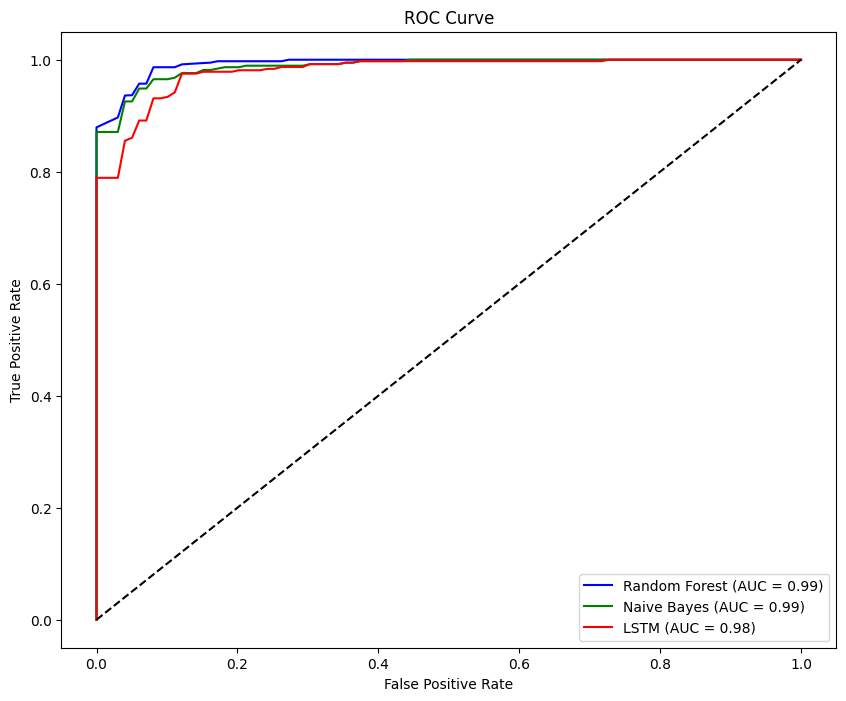

In [34]:
mean_fpr_rf, mean_tpr_rf = build_roc(fpr_rf, tpr_rf)
mean_fpr_nb, mean_tpr_nb = build_roc(fpr_nb, tpr_nb)
mean_fpr_lstm, mean_tpr_lstm = build_roc(fpr_lstm, tpr_lstm)

#Plotting the ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(mean_fpr_rf, mean_tpr_rf, color='b', label=f'Random Forest (AUC = {np.mean(auc_rf):.2f})')
plt.plot(mean_fpr_nb, mean_tpr_nb, color='g', label=f'Naive Bayes (AUC = {np.mean(auc_nb):.2f})')
plt.plot(mean_fpr_lstm, mean_tpr_lstm, color='r', label=f'LSTM (AUC = {np.mean(auc_lstm):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()